In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Exploratory Data Analysis


### What data we have?

#### Main info 

**Hramotiy** is a family-friendly creative shop operating in Ukraine for over six years.  
It specializes in educational and creative goods for children and adults.

**Main product categories:**
- Children’s books at publisher prices  
- Creative and art materials  
- Stationery and school supplies  
- Board games for kids and adults  
- Educational and wooden toys  
- Puzzles, constructors, and DIY kits  
- Science and sewing sets, paint-by-number art  
- Modeling materials: clay, kinetic sand, plasticine  

*Data covers the period from October 2017 to September 2025.*


#### Dataset Description

Each monthly CSV file summarizes sales by product category.

**Columns:**
- `category` — product category name  
- `supplier_sum` — total supplier purchase cost  
- `sold_qty` — number of sold items  
- `sold_cost` — cost value of sold goods  
- `sold_sum` — gross sales before returns  
- `return_qty` / `return_cost` / `return_sum` — quantity, cost, and value of returns  
- `revenue` — net sales after returns  
- `profit` — gross profit (revenue − sold_cost + return_cost)

Example categories: *Books, Toys, Games, Stationery, Constructors, Creativity, Science.*

This dataset will be used to analyze sales dynamics, category performance, and profitability trends over time.

#### Links
[website](https://gramotiy.com.ua/ua)  
[instagram](https://www.instagram.com/gramotiy_books_toys)

In [9]:
df = pd.read_csv('data/all_months_combined.csv')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('date')

### Basic info about data

In [10]:
print("\n1.1 Dataset Shape:")
print(f"   - Number of records: {len(df)}")
print(f"   - Number of features: {len(df.columns)}")
print(f"   - Date range: {df['date'].min().strftime('%B %Y')} to {df['date'].max().strftime('%B %Y')}")
print(f"   - Time span: {(df['date'].max() - df['date'].min()).days // 30} months")

print("\n1.2 Missing Values:")
print("-"*40)
missing = df.isnull().sum()

for col, count in missing[missing > 0].items():
    print(f"   {col}: {count} ({count/len(df)*100:.2f}%)")



1.1 Dataset Shape:
   - Number of records: 790
   - Number of features: 13
   - Date range: October 2017 to September 2025
   - Time span: 96 months

1.2 Missing Values:
----------------------------------------
   supplier_sum: 14 (1.77%)
   return_qty: 43 (5.44%)
   return_cost: 43 (5.44%)
   return_sum: 43 (5.44%)


Missing values mean 0 – 0 returns or 0 products sold so we are inserting 0 instead of none

In [11]:
return_cols = ['return_qty', 'return_cost', 'return_sum']
df[return_cols] = df[return_cols].fillna(0)
df['supplier_sum'] = df['supplier_sum'].fillna(0)

### Product categories analysis

In [12]:
categories = df['category'].unique()
print(f"\n2.1 Product Categories ({len(categories)} total):")
for i, cat in enumerate(categories, 1):
    total_revenue = df[df['category'] == cat]['revenue'].sum()
    print(f"   {i}. {cat:20s} - Total Revenue: {total_revenue:,.2f} UAH")


2.1 Product Categories (13 total):
   1. Іграшки              - Total Revenue: 1,587,508.06 UAH
   2. Творчість            - Total Revenue: 1,776,324.94 UAH
   3. Спорт                - Total Revenue: 45.00 UAH
   4. Пакет                - Total Revenue: 1,714.93 UAH
   5. Наочні посібники     - Total Revenue: 133,099.45 UAH
   6. Музика               - Total Revenue: 2,884.93 UAH
   7. Наука                - Total Revenue: 106,483.51 UAH
   8. Книга                - Total Revenue: 4,591,972.78 UAH
   9. Канцтовари           - Total Revenue: 478,714.36 UAH
   10. Інші                 - Total Revenue: 16,250.10 UAH
   11. Ігри                 - Total Revenue: 1,108,446.12 UAH
   12. Конструктори         - Total Revenue: 808,646.80 UAH
   13. Органіка             - Total Revenue: 598.00 UAH


In [13]:
print("\n2.2 Category Performance Metrics:")
print("-"*40)
category_stats = df.groupby('category').agg({
    'revenue': ['sum', 'mean', 'std'],
    'profit': ['sum', 'mean'],
    'sold_qty': 'sum',
    'return_qty': 'sum'
}).round(2)
print(category_stats)


2.2 Category Performance Metrics:
----------------------------------------
                     revenue                          profit            \
                         sum      mean       std         sum      mean   
category                                                                 
Іграшки           1587508.06  23694.15  14011.45   640380.82   9557.92   
Ігри              1108446.12  11918.78   6933.98   456353.24   4907.02   
Інші                16250.10    325.00    462.09     7159.39    143.19   
Канцтовари         478714.36   5260.60   3548.77   222902.41   2449.48   
Книга             4591972.78  49376.05  20168.40  1680508.65  18069.99   
Конструктори       808646.80   8789.64   8453.64   315091.12   3424.90   
Музика               2884.93    221.92    217.83     1096.31     84.33   
Наочні посібники   133099.45   1446.73    958.04    51754.14    562.54   
Наука              106483.51   1238.18   1155.36    40832.07    474.79   
Органіка              598.00    299.

### Time series characteristics

In [14]:
monthly_data = df.groupby('date').agg({
    'revenue': 'sum',
    'profit': 'sum',
    'sold_qty': 'sum',
    'return_qty': 'sum',
    'sold_cost': 'sum'
}).reset_index()

print("\n3.1 Monthly Revenue Statistics:")
print(f"   - Mean monthly revenue: {monthly_data['revenue'].mean():,.2f} UAH")
print(f"   - Median monthly revenue: {monthly_data['revenue'].median():,.2f} UAH")
print(f"   - Std deviation: {monthly_data['revenue'].std():,.2f} UAH")
print(f"   - Min monthly revenue: {monthly_data['revenue'].min():,.2f} UAH")
print(f"   - Max monthly revenue: {monthly_data['revenue'].max():,.2f} UAH")
print(f"   - Coefficient of Variation: {(monthly_data['revenue'].std()/monthly_data['revenue'].mean())*100:.2f}%")

print("\n3.2 Growth Rates:")
monthly_data['revenue_growth'] = monthly_data['revenue'].pct_change() * 100
avg_growth = monthly_data['revenue_growth'].mean()
print(f"   - Average monthly growth rate: {avg_growth:.2f}%")
print(f"   - Median growth rate: {monthly_data['revenue_growth'].median():.2f}%")
print(f"   - Growth volatility (std): {monthly_data['revenue_growth'].std():.2f}%")



3.1 Monthly Revenue Statistics:
   - Mean monthly revenue: 114,114.94 UAH
   - Median monthly revenue: 102,935.00 UAH
   - Std deviation: 60,117.58 UAH
   - Min monthly revenue: 1,435.00 UAH
   - Max monthly revenue: 391,261.44 UAH
   - Coefficient of Variation: 52.68%

3.2 Growth Rates:
   - Average monthly growth rate: 86.61%
   - Median growth rate: 2.57%
   - Growth volatility (std): 530.77%


### Seasonality 

In [15]:
# Extract month for seasonality
df['month_name'] = pd.to_datetime(df['date']).dt.strftime('%B')
df['month_num'] = df['month']

seasonal_revenue = df.groupby('month_num')['revenue'].agg(['mean', 'std', 'count'])
seasonal_revenue = seasonal_revenue.sort_index()

print("\n4.1 Average Revenue by Month:")
print("-"*40)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num in seasonal_revenue.index:
    if month_num <= 12:
        mean_rev = seasonal_revenue.loc[month_num, 'mean']
        std_rev = seasonal_revenue.loc[month_num, 'std']
        count = seasonal_revenue.loc[month_num, 'count']
        print(f"   {months[month_num-1]:3s}: Mean={mean_rev:8,.0f} UAH, Std={std_rev:8,.0f}, n={count:.0f}")

# Find peak and low seasons
peak_month = seasonal_revenue['mean'].idxmax()
low_month = seasonal_revenue['mean'].idxmin()
print(f"\n   📈 Peak season: {months[peak_month-1]} (avg: {seasonal_revenue.loc[peak_month, 'mean']:,.0f} UAH)")
print(f"   📉 Low season: {months[low_month-1]} (avg: {seasonal_revenue.loc[low_month, 'mean']:,.0f} UAH)")



4.1 Average Revenue by Month:
----------------------------------------
   Jan: Mean=  12,739 UAH, Std=  15,344, n=72
   Feb: Mean=  12,030 UAH, Std=  15,680, n=72
   Mar: Mean=  12,405 UAH, Std=  15,238, n=59
   Apr: Mean=   8,134 UAH, Std=  11,992, n=54
   May: Mean=   9,734 UAH, Std=  13,338, n=66
   Jun: Mean=  10,296 UAH, Std=  13,730, n=67
   Jul: Mean=  10,344 UAH, Std=  12,225, n=65
   Aug: Mean=  11,388 UAH, Std=  13,722, n=55
   Sep: Mean=  13,715 UAH, Std=  16,411, n=67
   Oct: Mean=  13,919 UAH, Std=  16,310, n=71
   Nov: Mean=  13,529 UAH, Std=  16,300, n=71
   Dec: Mean=  30,415 UAH, Std=  32,860, n=71

   📈 Peak season: Dec (avg: 30,415 UAH)
   📉 Low season: Apr (avg: 8,134 UAH)


We can see clear annual pattern across 8 years

### Profitability

In [16]:

# Calculate profit margins
df['profit_margin'] = (df['profit'] / df['revenue']) * 100
overall_margin = (df['profit'].sum() / df['revenue'].sum()) * 100

print(f"\n5.1 Overall Profit Metrics:")
print(f"   - Total Revenue: {df['revenue'].sum():,.2f} UAH")
print(f"   - Total Profit: {df['profit'].sum():,.2f} UAH")
print(f"   - Overall Profit Margin: {overall_margin:.2f}%")

print("\n5.2 Profit Margins by Category:")
print("-"*40)
category_margins = df.groupby('category').apply(
    lambda x: (x['profit'].sum() / x['revenue'].sum() * 100) if x['revenue'].sum() > 0 else 0
).sort_values(ascending=False)

for cat, margin in category_margins.items():
    print(f"   {cat:20s}: {margin:.2f}%")



5.1 Overall Profit Metrics:
   - Total Revenue: 10,612,688.98 UAH
   - Total Profit: 4,177,534.46 UAH
   - Overall Profit Margin: 39.36%

5.2 Profit Margins by Category:
----------------------------------------
   Пакет               : 51.24%
   Спорт               : 47.62%
   Канцтовари          : 46.56%
   Інші                : 44.06%
   Творчість           : 42.81%
   Ігри                : 41.17%
   Іграшки             : 40.34%
   Конструктори        : 38.97%
   Наочні посібники    : 38.88%
   Наука               : 38.35%
   Музика              : 38.00%
   Книга               : 36.60%
   Органіка            : 30.42%


Profit margin stable at 39.36%

### Return

In [17]:
total_returns = df['return_qty'].sum()
total_sold = df['sold_qty'].sum()
return_rate = (total_returns / total_sold) * 100

print(f"\n6.1 Overall Return Statistics:")
print(f"   - Total items sold: {total_sold:,.0f}")
print(f"   - Total items returned: {total_returns:,.0f}")
print(f"   - Overall return rate: {return_rate:.2f}%")

print("\n6.2 Returns by Category:")
print("-"*40)
category_returns = df.groupby('category').apply(
    lambda x: (x['return_qty'].sum() / x['sold_qty'].sum() * 100) if x['sold_qty'].sum() > 0 else 0
).sort_values(ascending=False)

for cat, rate in category_returns[category_returns > 0].items():
    qty_returned = df[df['category'] == cat]['return_qty'].sum()
    print(f"   {cat:20s}: {rate:.2f}% ({qty_returned:.0f} items)")



6.1 Overall Return Statistics:
   - Total items sold: 103,181
   - Total items returned: 437
   - Overall return rate: 0.42%

6.2 Returns by Category:
----------------------------------------
   Наука               : 1.52% (8 items)
   Конструктори        : 0.81% (17 items)
   Наочні посібники    : 0.72% (24 items)
   Іграшки             : 0.58% (63 items)
   Книга               : 0.38% (174 items)
   Канцтовари          : 0.38% (49 items)
   Творчість           : 0.37% (70 items)
   Ігри                : 0.36% (32 items)


### Visualizations

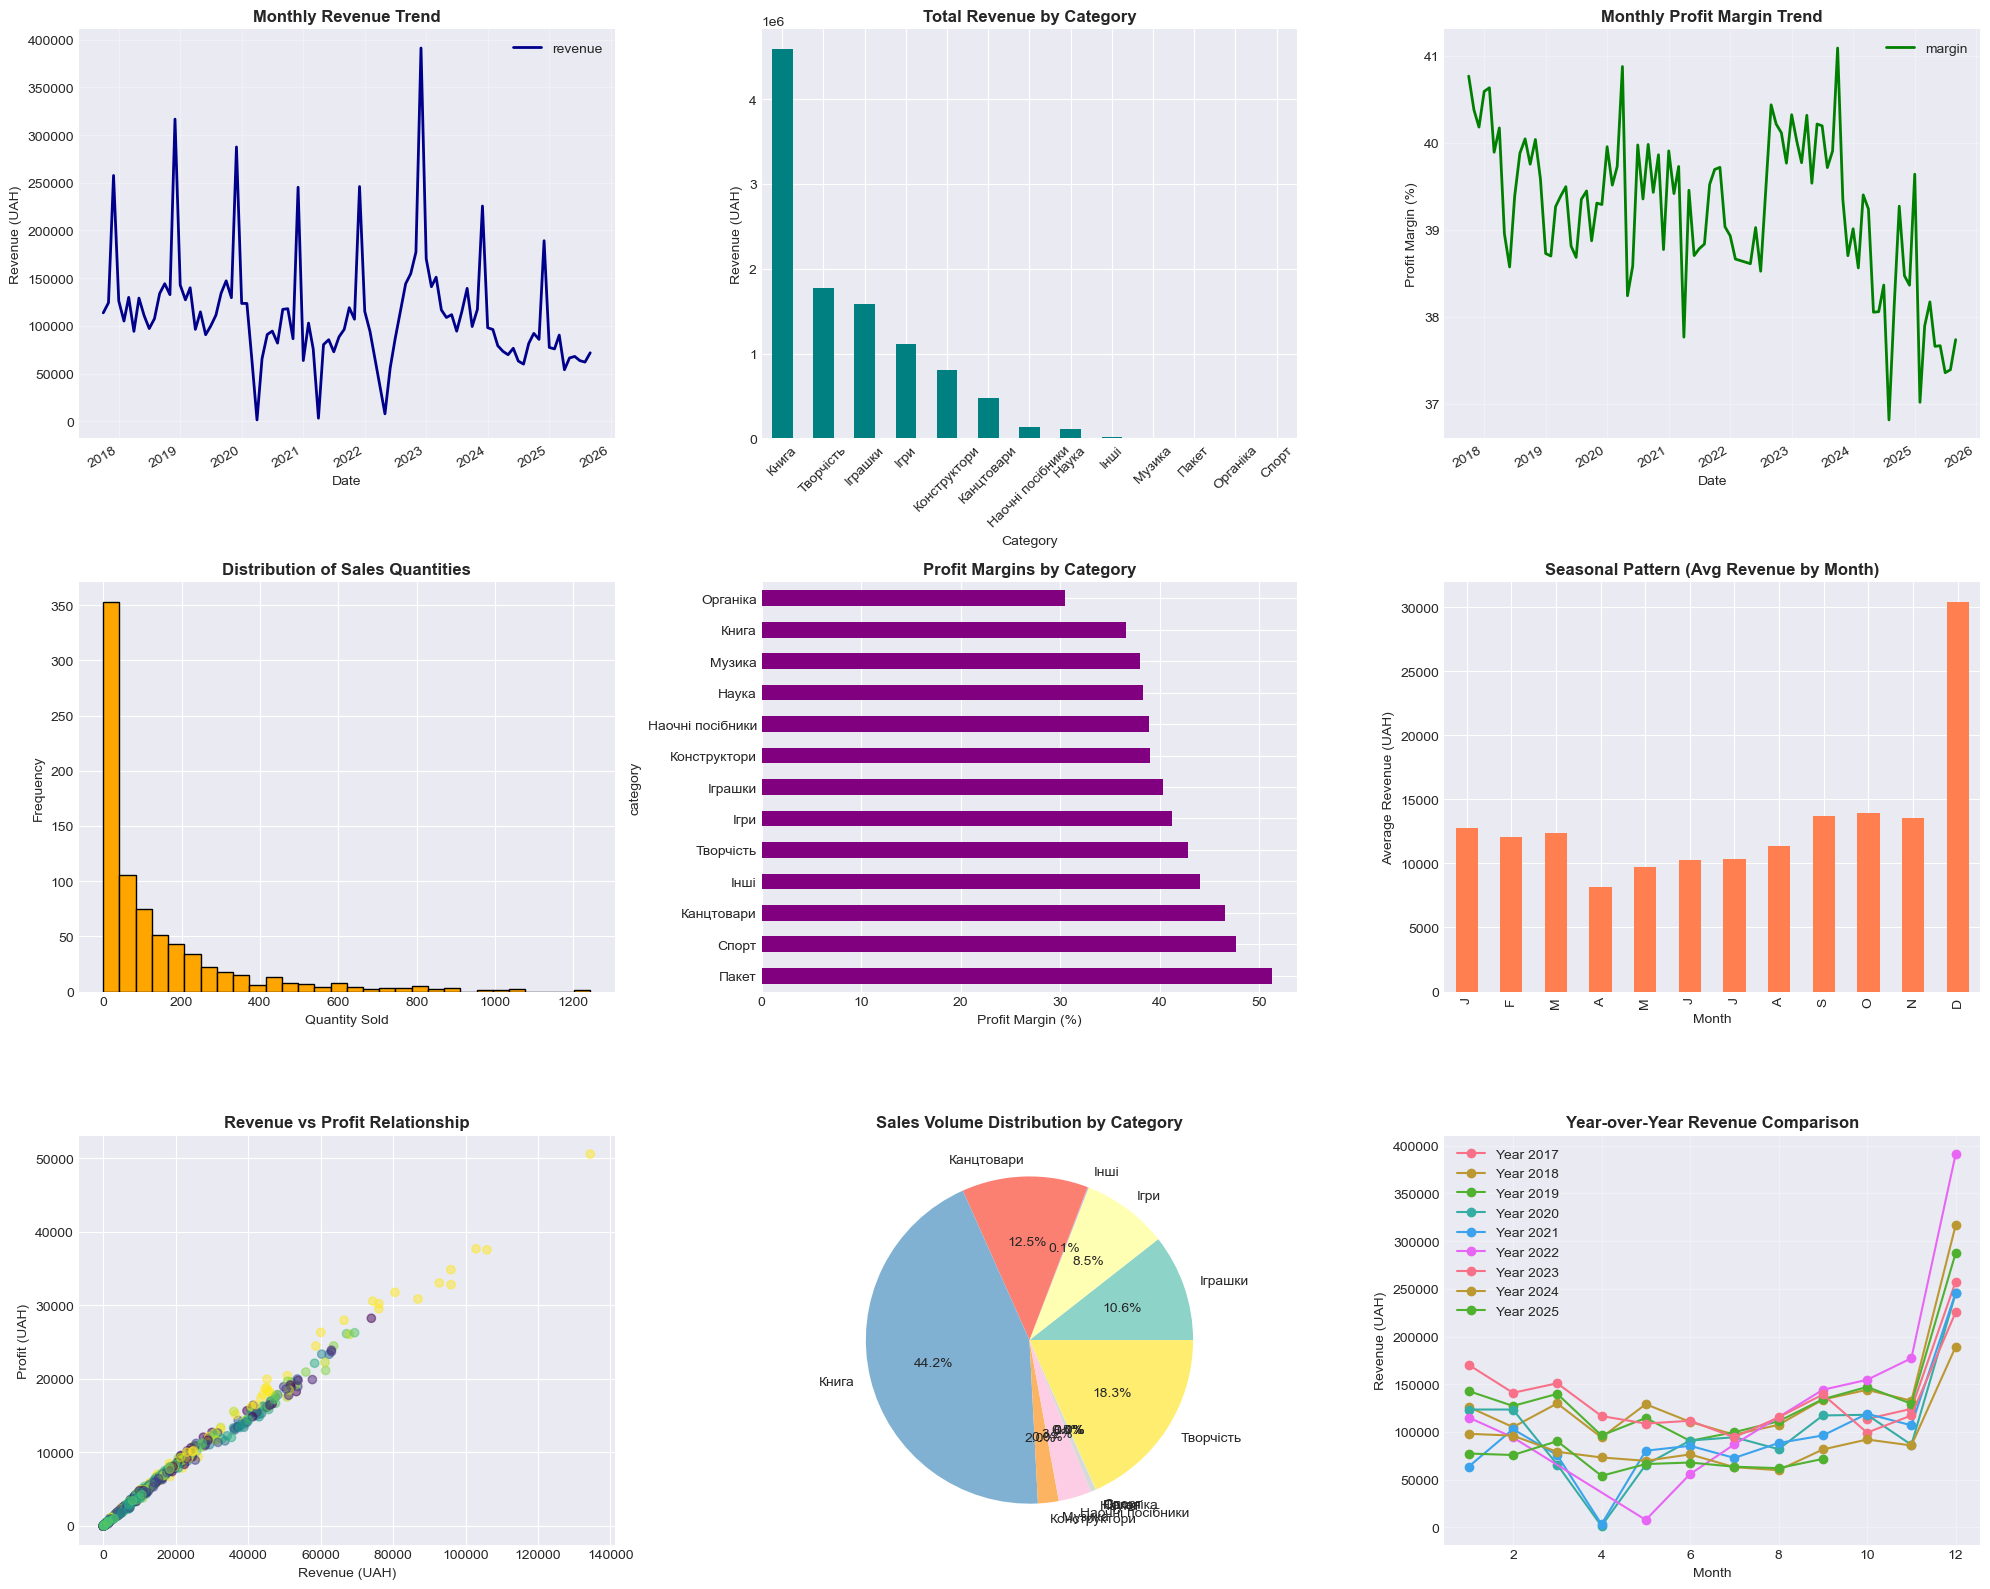

In [18]:
fig = plt.figure(figsize=(20, 16))

# 1. Monthly Revenue Trend
ax1 = plt.subplot(3, 3, 1)
monthly_data.plot(x='date', y='revenue', ax=ax1, color='darkblue', linewidth=2)
ax1.set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue (UAH)')
ax1.grid(True, alpha=0.3)

# 2. Revenue by Category (Bar)
ax2 = plt.subplot(3, 3, 2)
category_revenue = df.groupby('category')['revenue'].sum().sort_values(ascending=False)
category_revenue.plot(kind='bar', ax=ax2, color='teal')
ax2.set_title('Total Revenue by Category', fontsize=12, fontweight='bold')
ax2.set_xlabel('Category')
ax2.set_ylabel('Revenue (UAH)')
ax2.tick_params(axis='x', rotation=45)

# 3. Monthly Profit Margin Trend
ax3 = plt.subplot(3, 3, 3)
monthly_margin = monthly_data.copy()
monthly_margin['margin'] = (monthly_margin['profit'] / monthly_margin['revenue']) * 100
monthly_margin.plot(x='date', y='margin', ax=ax3, color='green', linewidth=2)
ax3.set_title('Monthly Profit Margin Trend', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Profit Margin (%)')
ax3.grid(True, alpha=0.3)

# 4. Sales Quantity Distribution
ax4 = plt.subplot(3, 3, 4)
df['sold_qty'].hist(bins=30, ax=ax4, color='orange', edgecolor='black')
ax4.set_title('Distribution of Sales Quantities', fontsize=12, fontweight='bold')
ax4.set_xlabel('Quantity Sold')
ax4.set_ylabel('Frequency')

# 5. Category Profit Margins
ax5 = plt.subplot(3, 3, 5)
category_margins.plot(kind='barh', ax=ax5, color='purple')
ax5.set_title('Profit Margins by Category', fontsize=12, fontweight='bold')
ax5.set_xlabel('Profit Margin (%)')

# 6. Seasonal Pattern (Average Revenue by Month)
ax6 = plt.subplot(3, 3, 6)
seasonal_pattern = df.groupby('month')['revenue'].mean().sort_index()
seasonal_pattern.plot(kind='bar', ax=ax6, color='coral')
ax6.set_title('Seasonal Pattern (Avg Revenue by Month)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Month')
ax6.set_ylabel('Average Revenue (UAH)')
ax6.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

# 7. Revenue vs Profit Scatter
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(df['revenue'], df['profit'], alpha=0.5, c=df['month'], cmap='viridis')
ax7.set_title('Revenue vs Profit Relationship', fontsize=12, fontweight='bold')
ax7.set_xlabel('Revenue (UAH)')
ax7.set_ylabel('Profit (UAH)')

# 8. Category Sales Volume Pie Chart
ax8 = plt.subplot(3, 3, 8)
category_qty = df.groupby('category')['sold_qty'].sum()
colors = plt.cm.Set3(range(len(category_qty)))
ax8.pie(category_qty, labels=category_qty.index, autopct='%1.1f%%', colors=colors)
ax8.set_title('Sales Volume Distribution by Category', fontsize=12, fontweight='bold')

# 9. Year-over-Year Comparison (if applicable)
ax9 = plt.subplot(3, 3, 9)
yearly_revenue = df.groupby(['year', 'month']).agg({'revenue': 'sum'}).reset_index()
for year in yearly_revenue['year'].unique():
    year_data = yearly_revenue[yearly_revenue['year'] == year]
    ax9.plot(year_data['month'], year_data['revenue'], marker='o', label=f'Year {year}')
ax9.set_title('Year-over-Year Revenue Comparison', fontsize=12, fontweight='bold')
ax9.set_xlabel('Month')
ax9.set_ylabel('Revenue (UAH)')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Outliers analysis

In results we see that we have not only seasonality but outliers also. lets investigate this situation:

Q1: 1237.53, Q3: 17438.64, IQR: 16201.11
Bounds: [-23064.15, 41740.31]

Total outliers: 75 (9.49%)

Outliers by month:
month
12    24
2      7
9      7
10     7
11     6
6      5
1      5
3      5
8      3
5      3
7      2
4      1
dtype: int64


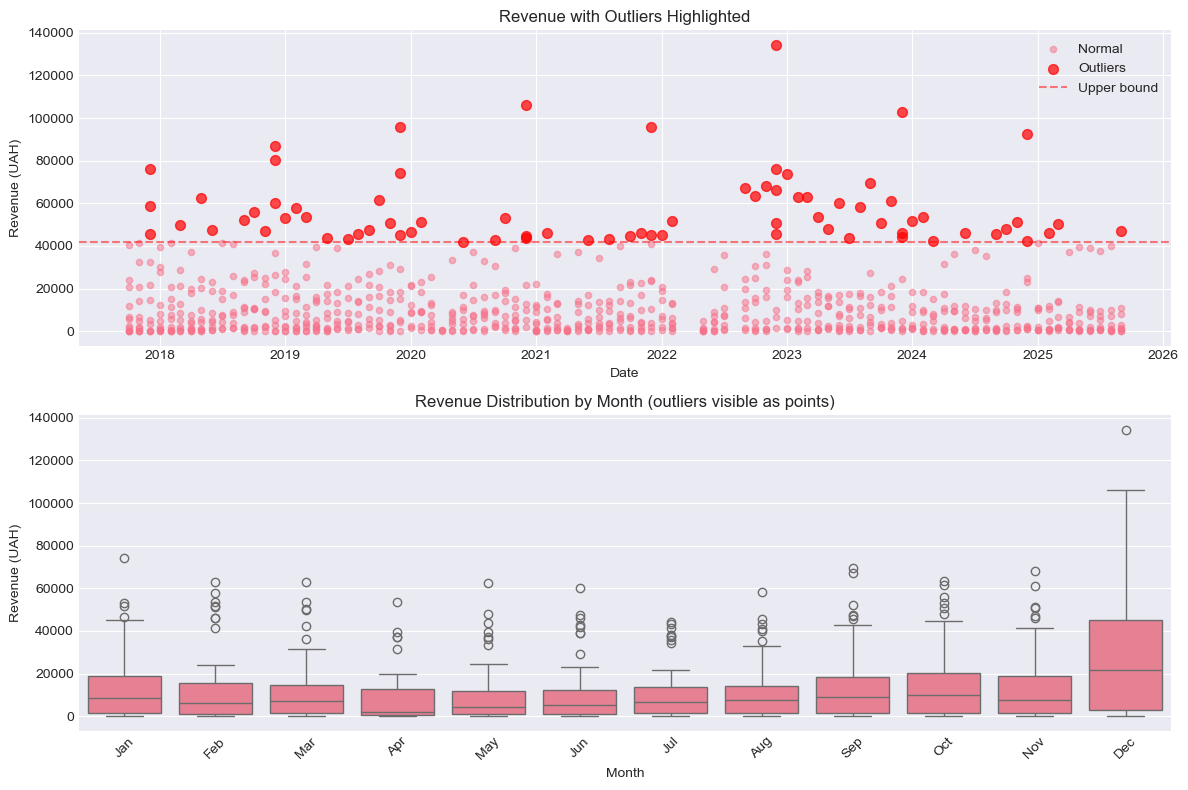


Top 10 highest outliers:
          date    revenue category
520 2022-12-01  134405.63    Книга
346 2020-12-01  105916.90    Книга
620 2023-12-01  102898.66    Книга
254 2019-12-01   96003.96    Книга
447 2021-12-01   95950.15    Книга
714 2024-12-01   92753.51    Книга
144 2018-12-01   86860.07    Книга
140 2018-12-01   80513.18  Іграшки
517 2022-12-01   76098.12  Іграшки
27  2017-12-01   76036.90    Книга


In [19]:
Q1 = df['revenue'].quantile(0.25)
Q3 = df['revenue'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

df['is_outlier'] = (df['revenue'] < lower_bound) | (df['revenue'] > upper_bound)
outliers = df[df['is_outlier']]

print(f"\nTotal outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

df['month'] = pd.to_datetime(df['date']).dt.month
outliers_by_month = outliers.groupby('month').size()

print("\nOutliers by month:")
print(outliers_by_month.sort_values(ascending=False))

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].scatter(df[~df['is_outlier']]['date'], df[~df['is_outlier']]['revenue'], 
                alpha=0.5, s=20, label='Normal')
axes[0].scatter(outliers['date'], outliers['revenue'], 
                color='red', s=50, alpha=0.7, label='Outliers')
axes[0].axhline(y=upper_bound, color='r', linestyle='--', alpha=0.5, label='Upper bound')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue (UAH)')
axes[0].set_title('Revenue with Outliers Highlighted')
axes[0].legend()

df['month_name'] = pd.to_datetime(df['date']).dt.strftime('%b')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(data=df, x='month_name', y='revenue', order=month_order, ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Revenue (UAH)')
axes[1].set_title('Revenue Distribution by Month (outliers visible as points)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nTop 10 highest outliers:")
print(outliers.nlargest(10, 'revenue')[['date', 'revenue', 'category']])

### Conclusions

Based on EDA we can make some conclusions:

- Our data is strongly seasonal: December is 3.7x higher than April. Model absolutely needs to capture this seasonal pattern (maybe SARIMA or smt).

- Series are pretty noisy: CV of 52.68% and crazy growth volatility (530.77%). We might need smoothing.

- Outliers are seasonal – mostly january sales. 

- The growth rates stats (86% mean but 2.57% median) suggest we have some extreme months skewing things.

Good to know:

- Returns are negligible (0.42%) - won't affect forecasts

- Product mix is stable with Books + Art as main drivers


# Baseline – SARIMA

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

monthly_data = df.groupby(['year', 'month'])['revenue'].sum().reset_index()
monthly_data['date'] = pd.to_datetime(
    monthly_data['year'].astype(str) + '-' + 
    monthly_data['month'].astype(str) + '-01'
)
monthly_data = monthly_data.sort_values('date').set_index('date')

ts = monthly_data['revenue']

print(f"Data: {len(ts)} months from {ts.index[0]} to {ts.index[-1]}")


Data: 93 months from 2017-10-01 00:00:00 to 2025-09-01 00:00:00


In [21]:
train_size = len(ts) - 12
train = ts[:train_size]
test = ts[train_size:]

print(f"Train: {len(train)} months, Test: {len(test)} months")

Train: 81 months, Test: 12 months


## Exploratory analysis

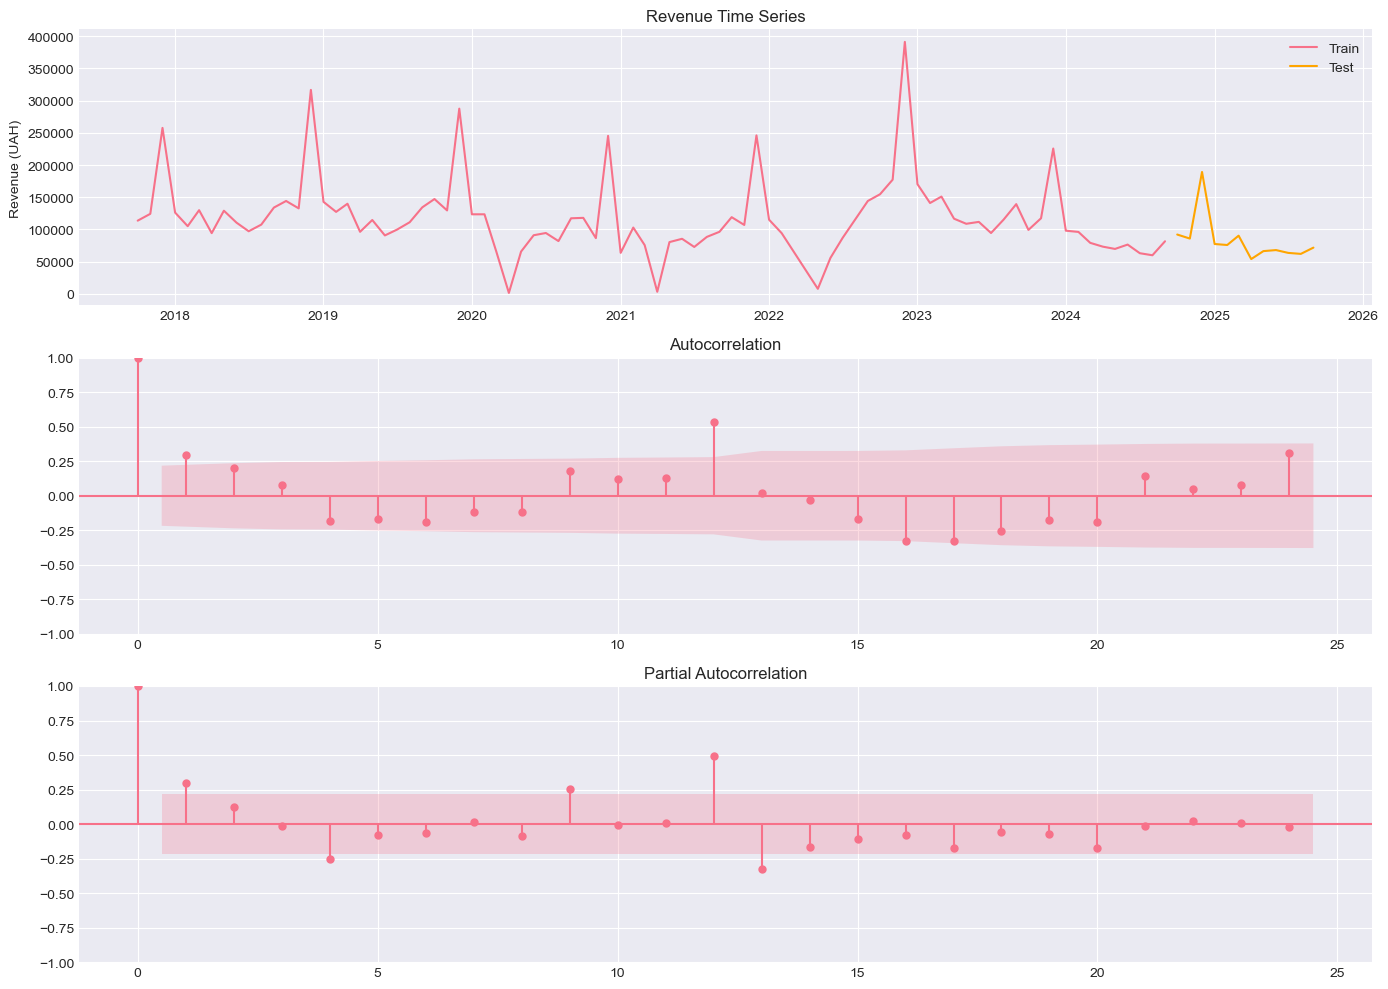

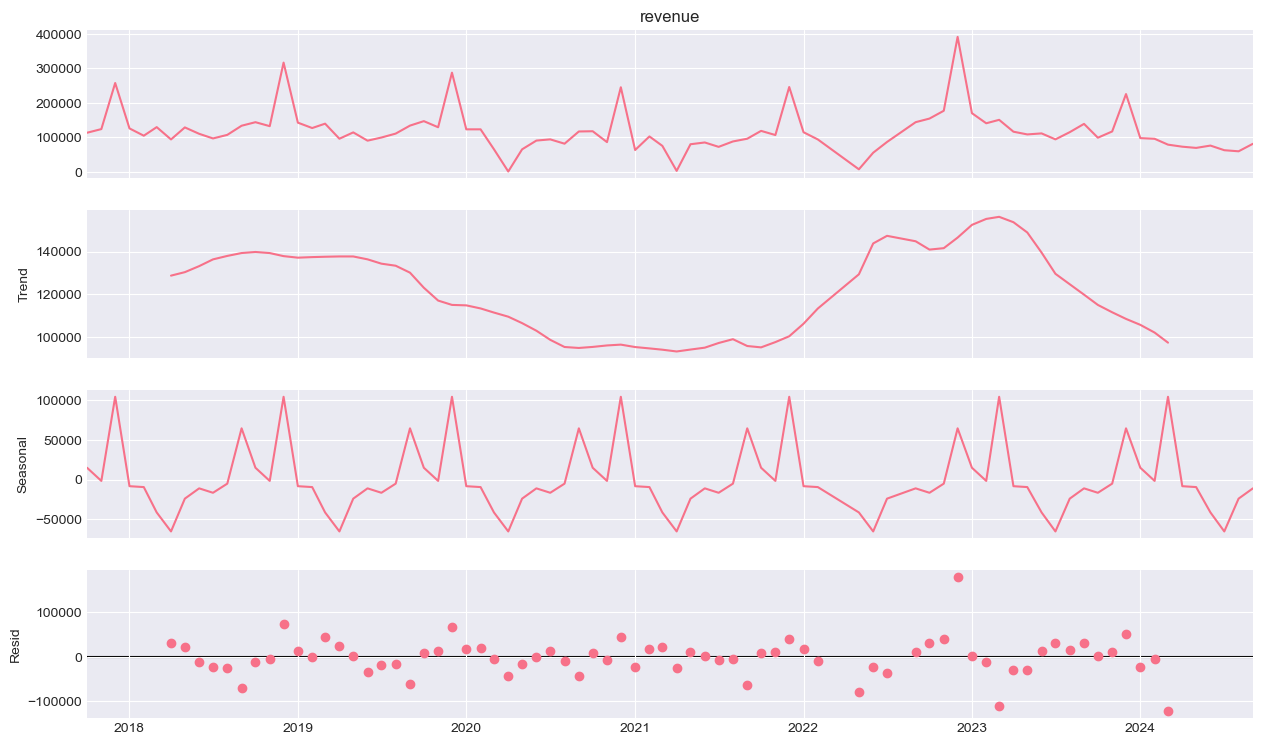

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(train.index, train.values, label='Train')
axes[0].plot(test.index, test.values, label='Test', color='orange')
axes[0].set_title('Revenue Time Series')
axes[0].legend()
axes[0].set_ylabel('Revenue (UAH)')

plot_acf(train, lags=24, ax=axes[1])
plot_pacf(train, lags=24, ax=axes[2])

plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(train, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()


In [23]:
def evaluate_sarima(train, test, order, seasonal_order):
    """trains and evaluates SARIMA model"""
    try:
        model = SARIMAX(train, 
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        
        fitted_model = model.fit(disp=False, maxiter=200)
        forecast = fitted_model.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = mean_absolute_percentage_error(test, forecast) * 100
        
        return {
            'model': fitted_model,
            'forecast': forecast,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic
        }
    except:
        return None


## Full grid search

Total configurations to test: 216
This may take a few minutes...



Non-seasonal params:   0%|          | 0/18 [00:00<?, ?it/s]c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored 


✅ Successfully fitted: 215 models
❌ Failed: 0 models

TOP 10 MODELS BY MAPE:
SARIMA(2, 1, 2)x(2, 0, 0, 12): MAPE=8.99%, MAE=6783.93, AIC=1339.78
SARIMA(1, 1, 2)x(2, 0, 0, 12): MAPE=10.06%, MAE=7679.01, AIC=1362.89
SARIMA(2, 0, 0)x(2, 0, 0, 12): MAPE=10.41%, MAE=8669.14, AIC=1359.58
SARIMA(1, 0, 1)x(2, 0, 0, 12): MAPE=10.50%, MAE=8681.09, AIC=1381.95
SARIMA(2, 0, 2)x(2, 0, 0, 12): MAPE=10.60%, MAE=8881.01, AIC=1362.81
SARIMA(1, 0, 0)x(1, 0, 1, 12): MAPE=10.70%, MAE=8069.20, AIC=1680.85
SARIMA(0, 0, 0)x(1, 0, 0, 12): MAPE=10.99%, MAE=8585.93, AIC=1708.42
SARIMA(2, 0, 1)x(2, 0, 0, 12): MAPE=11.15%, MAE=9592.58, AIC=1358.97
SARIMA(2, 0, 2)x(1, 0, 1, 12): MAPE=11.77%, MAE=9574.83, AIC=1626.28
SARIMA(1, 1, 1)x(2, 0, 0, 12): MAPE=11.89%, MAE=9091.95, AIC=1360.47

TOP 10 MODELS BY AIC:
SARIMA(2, 1, 2)x(2, 1, 1, 12): AIC=1048.91, MAPE=23.57%, MAE=23487.33
SARIMA(2, 1, 2)x(2, 1, 0, 12): AIC=1049.50, MAPE=30.44%, MAE=27069.87
SARIMA(2, 1, 0)x(2, 1, 1, 12): AIC=1050.10, MAPE=121.77%, MAE=88202.57

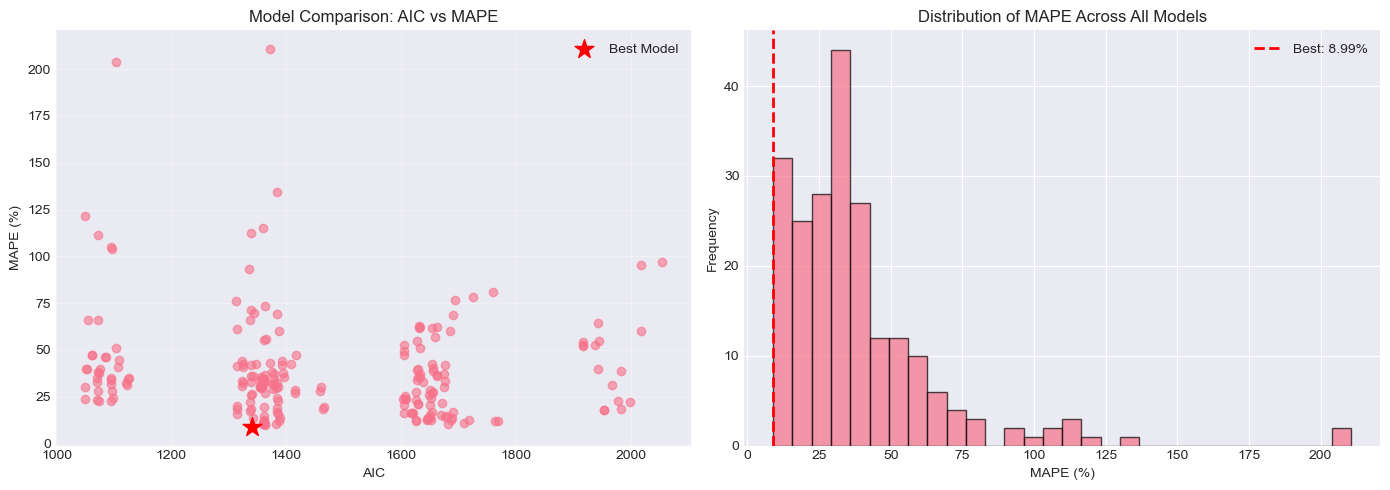


📊 Full results saved to 'sarima_grid_search_results.csv'


In [24]:
import itertools
from tqdm import tqdm 

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1]
S = 12

pdq_combinations = list(itertools.product(p_values, d_values, q_values))
PDQ_combinations = list(itertools.product(P_values, D_values, Q_values, [S]))

total_combinations = len(pdq_combinations) * len(PDQ_combinations)
print(f"Total configurations to test: {total_combinations}")
print("This may take a few minutes...\n")

results = []
failed_configs = []

for pdq in tqdm(pdq_combinations, desc="Non-seasonal params"):
    for PDQ in PDQ_combinations:
        try:
        
        
            if pdq == (0, 0, 0) and PDQ == (0, 0, 0, 12):
                continue
                
            model = SARIMAX(train, 
                           order=pdq,
                           seasonal_order=PDQ,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
            
        
            forecast = fitted_model.forecast(steps=len(test))
            
        
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            mape = mean_absolute_percentage_error(test, forecast) * 100
            
            results.append({
                'order': pdq,
                'seasonal_order': PDQ,
                'model': fitted_model,
                'forecast': forecast,
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic
            })
            
        except Exception as e:
            failed_configs.append({
                'order': pdq,
                'seasonal_order': PDQ,
                'error': str(e)
            })
            continue

print(f"\n✅ Successfully fitted: {len(results)} models")
print(f"❌ Failed: {len(failed_configs)} models")

results_df = pd.DataFrame([{
    'order': r['order'],
    'seasonal_order': r['seasonal_order'],
    'mape': r['mape'],
    'mae': r['mae'],
    'rmse': r['rmse'],
    'aic': r['aic'],
    'bic': r['bic']
} for r in results])

print("\n" + "="*60)
print("TOP 10 MODELS BY MAPE:")
print("="*60)
top_mape = results_df.nsmallest(10, 'mape')
for idx, row in top_mape.iterrows():
    print(f"SARIMA{row['order']}x{row['seasonal_order']}: "
          f"MAPE={row['mape']:.2f}%, MAE={row['mae']:.2f}, "
          f"AIC={row['aic']:.2f}")

print("\n" + "="*60)
print("TOP 10 MODELS BY AIC:")
print("="*60)
top_aic = results_df.nsmallest(10, 'aic')
for idx, row in top_aic.iterrows():
    print(f"SARIMA{row['order']}x{row['seasonal_order']}: "
          f"AIC={row['aic']:.2f}, MAPE={row['mape']:.2f}%, "
          f"MAE={row['mae']:.2f}")

best_idx = results_df['mape'].idxmin()
best_result = results[best_idx]

print("\n" + "="*60)
print("BEST MODEL (by MAPE):")
print(f"SARIMA{best_result['order']}x{best_result['seasonal_order']}")
print(f"MAPE: {best_result['mape']:.2f}%")
print(f"MAE: {best_result['mae']:.2f}")
print(f"RMSE: {best_result['rmse']:.2f}")
print(f"AIC: {best_result['aic']:.2f}")
print(f"BIC: {best_result['bic']:.2f}")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(results_df['aic'], results_df['mape'], alpha=0.6)
axes[0].scatter(best_result['aic'], best_result['mape'], 
               color='red', s=200, marker='*', label='Best Model')
axes[0].set_xlabel('AIC')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_title('Model Comparison: AIC vs MAPE')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(results_df['mape'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(best_result['mape'], color='red', linestyle='--', 
               linewidth=2, label=f"Best: {best_result['mape']:.2f}%")
axes[1].set_xlabel('MAPE (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of MAPE Across All Models')
axes[1].legend()

plt.tight_layout()
plt.show()

results_df.to_csv('sarima_grid_search_results.csv', index=False)
print("\n📊 Full results saved to 'sarima_grid_search_results.csv'")

The full search grid revealed that the more complex AR/MA components (2,1,2) and the AR seasonal conditions (P=2) without seasonal difference (D=0) give the best forecast accuracy (MAPE=8.99%). This indicates a stable multiplicative seasonality in the data. The model shows a significant improvement over the baseline configuration (MAPE 22% → 9%).

## Final SARIMA

In [25]:
best_order = (2, 1, 2)
best_seasonal_order = (2, 0, 0, 12)

final_model = SARIMAX(ts, 
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

final_fitted = final_model.fit(disp=False, maxiter=200)

print(f"\nAIC: {final_fitted.aic:.2f}")
print(f"BIC: {final_fitted.bic:.2f}")


c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



AIC: 1624.70
BIC: 1640.03


## Forecast

In [26]:
n_periods = 12
forecast = final_fitted.forecast(steps=n_periods)
forecast_obj = final_fitted.get_forecast(steps=n_periods)
forecast_ci = forecast_obj.conf_int()

last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=n_periods, 
                             freq='MS')

forecast_df = pd.DataFrame({
    'Month': future_dates.strftime('%Y-%m'),
    'Forecast': forecast.values,
    'Lower_95CI': forecast_ci.iloc[:, 0].values,
    'Upper_95CI': forecast_ci.iloc[:, 1].values
})

print("\n2026 Monthly Revenue Forecast:")
print(forecast_df.to_string(index=False))

print(f"\n2026 Forecast Summary:")
print(f"  Total annual revenue: {forecast.sum():,.2f} UAH")
print(f"  Average monthly revenue: {forecast.mean():,.2f} UAH")
print(f"  Peak month: {future_dates[forecast.argmax()].strftime('%B')} ({forecast.max():,.2f} UAH)")
print(f"  Low month: {future_dates[forecast.argmin()].strftime('%B')} ({forecast.min():,.2f} UAH)")



2026 Monthly Revenue Forecast:
  Month      Forecast     Lower_95CI    Upper_95CI
2025-10  70647.940369  -50070.617046 191366.497784
2025-11  71641.257557  -62119.151608 205401.666722
2025-12 143272.258811   -2787.764293 289332.281914
2026-01  64484.643841  -86169.375090 215138.662772
2026-02  63600.344670  -91783.599189 218984.288529
2026-03  67077.278069  -91276.929026 225431.485164
2026-04  48717.452130 -112676.865960 210111.770220
2026-05  53866.978775 -110036.305187 217770.262736
2026-06  56017.580322 -110411.318080 222446.478725
2026-07  51236.669256 -117527.073560 220000.412073
2026-08  49874.950557 -121214.794930 220964.696043
2026-09  58873.303748 -114460.038889 232206.646384

2026 Forecast Summary:
  Total annual revenue: 799,310.66 UAH
  Average monthly revenue: 66,609.22 UAH
  Peak month: December (143,272.26 UAH)
  Low month: April (48,717.45 UAH)


c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jenia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Residual analysis

In [29]:
residuals = final_fitted.resid

# Basic statistics
print(f"\nResiduals Statistics:")
print(f"  Mean: {residuals.mean():.2f}")
print(f"  Std Dev: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

# Normality tests
print("\nNormality Tests:")

# 1. Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"  Shapiro-Wilk test:")
print(f"    Statistic: {shapiro_stat:.4f}")
print(f"    p-value: {shapiro_p:.4f}")
print(f"    Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'} (at α=0.05)")

# 2. Jarque-Bera test
jb_stat, jb_p = stats.jarque_bera(residuals)
print(f"\n  Jarque-Bera test:")
print(f"    Statistic: {jb_stat:.4f}")
print(f"    p-value: {jb_p:.4f}")
print(f"    Result: {'Normal' if jb_p > 0.05 else 'Not Normal'} (at α=0.05)")

# 3. Anderson-Darling test
ad_result = stats.anderson(residuals, dist='norm')
print(f"\n  Anderson-Darling test:")
print(f"    Statistic: {ad_result.statistic:.4f}")
print(f"    Critical values: {ad_result.critical_values}")
print(f"    Result: {'Normal' if ad_result.statistic < ad_result.critical_values[2] else 'Not Normal'} (at 5% significance)")

# Skewness and Kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)
print(f"\n  Skewness: {skewness:.4f} (normal: 0)")
print(f"  Kurtosis: {kurtosis:.4f} (normal: 0)")



Residuals Statistics:
  Mean: -3085.11
  Std Dev: 45230.60
  Min: -101668.83
  Max: 235422.37

Normality Tests:
  Shapiro-Wilk test:
    Statistic: 0.8580
    p-value: 0.0000
    Result: Not Normal (at α=0.05)

  Jarque-Bera test:
    Statistic: 291.4153
    p-value: 0.0000
    Result: Not Normal (at α=0.05)

  Anderson-Darling test:
    Statistic: 2.7848
    Critical values: [0.554 0.631 0.757 0.883 1.05 ]
    Result: Not Normal (at 5% significance)

  Skewness: 1.8171 (normal: 0)
  Kurtosis: 7.8738 (normal: 0)


## Visualization

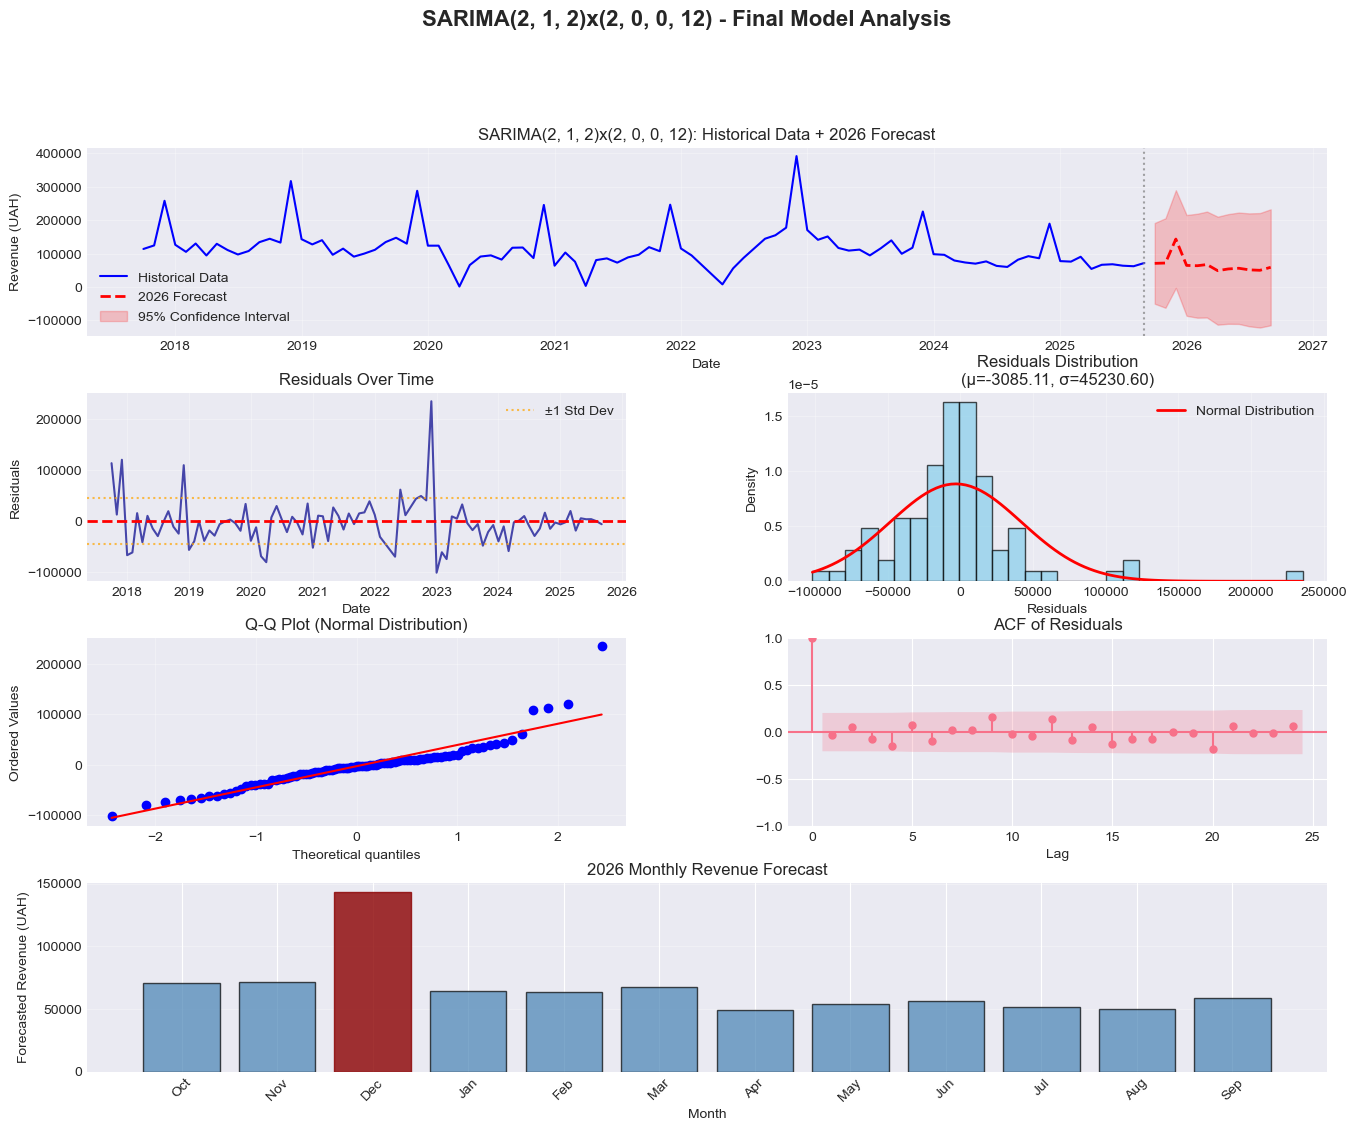

In [30]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Plot 1: Historical + Forecast
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(ts.index, ts.values, label='Historical Data', color='blue', linewidth=1.5)
ax1.plot(future_dates, forecast.values, label='2026 Forecast', 
         color='red', linestyle='--', linewidth=2)
ax1.fill_between(future_dates, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 alpha=0.2, color='red', label='95% Confidence Interval')
ax1.axvline(x=ts.index[-1], color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue (UAH)')
ax1.set_title(f'SARIMA{best_order}x{best_seasonal_order}: Historical Data + 2026 Forecast')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals over time
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(residuals.index, residuals.values, color='darkblue', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=residuals.std(), color='orange', linestyle=':', alpha=0.7, label='±1 Std Dev')
ax2.axhline(y=-residuals.std(), color='orange', linestyle=':', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals Over Time')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Residuals histogram with normal curve
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Fit normal distribution
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax3.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Density')
ax3.set_title(f'Residuals Distribution\n(μ={mu:.2f}, σ={sigma:.2f})')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Q-Q plot
ax4 = fig.add_subplot(gs[2, 0])
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normal Distribution)')
ax4.grid(alpha=0.3)

# Plot 5: ACF of residuals
ax5 = fig.add_subplot(gs[2, 1])
plot_acf(residuals, lags=24, ax=ax5)
ax5.set_title('ACF of Residuals')
ax5.set_xlabel('Lag')

# Plot 6: Forecast by month (seasonal pattern)
ax6 = fig.add_subplot(gs[3, :])
months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
ax6.bar(months, forecast.values, color='steelblue', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Month')
ax6.set_ylabel('Forecasted Revenue (UAH)')
ax6.set_title('2026 Monthly Revenue Forecast')
ax6.grid(axis='y', alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

# Highlight December
dec_idx = 2  # December is the 3rd month (Oct, Nov, Dec)
ax6.patches[dec_idx].set_color('darkred')
ax6.patches[dec_idx].set_alpha(0.8)

plt.suptitle(f'SARIMA{best_order}x{best_seasonal_order} - Final Model Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


## Model summary

In [31]:
print(final_fitted.summary())


                                      SARIMAX Results                                      
Dep. Variable:                             revenue   No. Observations:                   93
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood                -805.351
Date:                             Sun, 02 Nov 2025   AIC                           1624.702
Time:                                     23:11:08   BIC                           1640.029
Sample:                                          0   HQIC                          1630.759
                                              - 93                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0351      1.328     -0.026      0.979      -2.637       2.567
ar.L2          0.3440      

## Conclusion

The SARIMA(2,1,2)x(2,0,0,12) model achieves strong predictive performance with MAPE=8.99%, 
successfully capturing the pronounced seasonal patterns in monthly revenue data. 

The Ljung-Box test (p=0.80) confirms no residual autocorrelation, validating that temporal structure has 
been adequately modeled. 

However, the model exhibits several limitations: 
- (1) all coefficients are statistically insignificant (p>0.10), suggesting potential over-parameterization; 
- (2) residuals violate normality assumptions (Jarque-Bera p<0.001, skewness=1.82, kurtosis=7.87), indicating a heavy-tailed distribution with more extreme values than expected; and 
- (3) heteroskedasticity is present (H=0.36, p=0.02). 

These violations mean that while point forecasts are reliable for operational planning, the 95% confidence intervals likely 
underestimate true forecast uncertainty. For retail revenue forecasting with high volatility 
(CV=52.68%), the model provides adequate accuracy, though variance-stabilizing transformations 
or robust methods could improve reliability of uncertainty estimates.


# ML approaches

## LSTM 

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

print("✅ TensorFlow and Deep Learning libraries imported successfully")


✅ TensorFlow and Deep Learning libraries imported successfully


In [ ]:
train_vals = ts.values[:-12].reshape(-1, 1)
test_vals  = ts.values[-12:].reshape(-1, 1)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
test_scaled  = scaler.transform(test_vals)

def create_sequences(data, lookback=12):
    """Create sequences for time series prediction"""
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 12
all_scaled = np.vstack([train_scaled, test_scaled])
X, y = create_sequences(all_scaled, lookback=lookback)

print(f"\nSequence creation:")
print(f"  - Lookback window: {lookback} months")
print(f"  - X shape: {X.shape}")
print(f"  - y shape: {y.shape}")

train_idx = len(X) - 12
X_train, X_test = X[:train_idx], X[train_idx:]
y_train, y_test = y[:train_idx], y[train_idx:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nTrain/Test split:")
print(f"  - X_train shape: {X_train.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - X_test shape: {X_test.shape}")
print(f"  - y_test shape: {y_test.shape}")



Sequence creation:
  - Lookback window: 12 months
  - X shape: (81, 12)
  - y shape: (81,)

Train/Test split:
  - X_train shape: (69, 12, 1)
  - y_train shape: (69,)
  - X_test shape: (12, 12, 1)
  - y_test shape: (12,)


In [ ]:

model = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("LSTM Model Architecture:")
print("="*60)
model.summary()
print("="*60)
print(f"\nTotal parameters: {model.count_params():,}")


LSTM Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 4,385


Training LSTM model...
------------------------------------------------------------
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0858 - mae: 0.2423 - val_loss: 0.0188 - val_mae: 0.0902
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0413 - mae: 0.1326 - val_loss: 0.0120 - val_mae: 0.0925
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0309 - mae: 0.1196 - val_loss: 0.0250 - val_mae: 0.1559
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0319 - mae: 0.1316 - val_loss: 0.0171 - val_mae: 0.1246
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - mae: 0.1084 - val_loss: 0.0123 - val_mae: 0.0941
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0295 - mae: 0.1038 - val_loss: 0.0121 - val_mae: 0.0923
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0294 - mae: 0.1050 - val_loss: 0.0137 - val_mae: 0.1048
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - mae: 0.1076 - val_loss: 0.0149 - val_ma

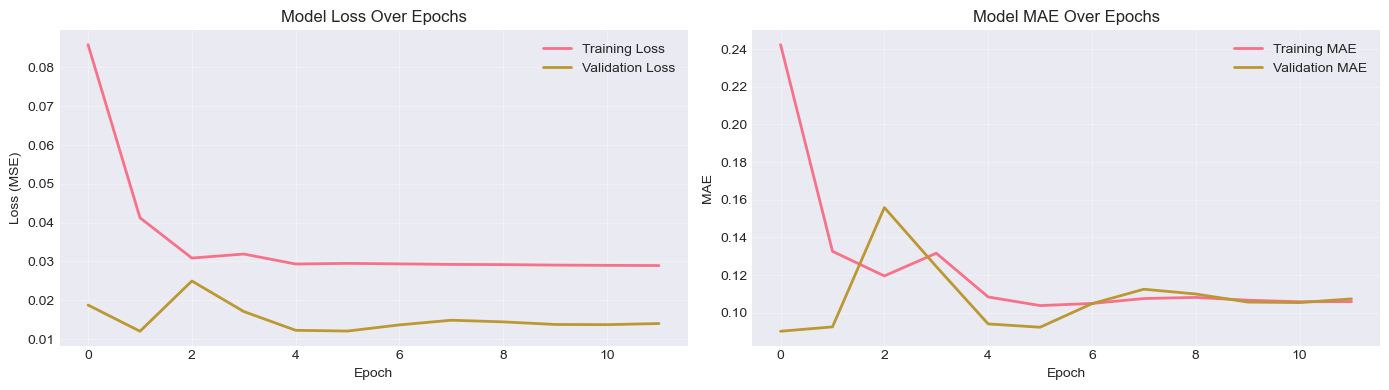

In [ ]:
print("Training LSTM model...")
print("-" * 60)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

val_size = 12
X_train_main, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_main, y_val = y_train[:-val_size], y_train[-val_size:]

history = model.fit(
    X_train_main, y_train_main,
    epochs=100,
    batch_size=8,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[early_stop],
)


print(f"✅ Training completed!")
print(f"  - Epochs trained: {len(history.history['loss'])}")
print(f"  - Final training loss: {history.history['loss'][-1]:.6f}")
print(f"  - Final validation loss: {history.history['val_loss'][-1]:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss Over Epochs')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Model MAE Over Epochs')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_scaled = scaler.inverse_transform(y_train_pred)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_scaled = scaler.inverse_transform(y_test_pred)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

train_mae = mean_absolute_error(y_train_actual, y_train_pred_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_scaled))
train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred_scaled) * 100

test_mae = mean_absolute_error(y_test_actual, y_test_pred_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_scaled))
test_mape = mean_absolute_percentage_error(y_test_actual, y_test_pred_scaled) * 100

print("\n" + "="*60)
print("LSTM MODEL PERFORMANCE")
print("="*60)
print(f"\nTraining Set:")
print(f"  - MAE:  {train_mae:,.2f} UAH")
print(f"  - RMSE: {train_rmse:,.2f} UAH")
print(f"  - MAPE: {train_mape:.2f}%")

print(f"\nTest Set:")
print(f"  - MAE:  {test_mae:,.2f} UAH")
print(f"  - RMSE: {test_rmse:,.2f} UAH")
print(f"  - MAPE: {test_mape:.2f}%")

print(f"\n{'COMPARISON WITH SARIMA':^60}")
print("-"*60)
print(f"{'Metric':<15} {'LSTM':<20} {'SARIMA':<20}")
print("-"*60)
print(f"{'Test MAPE':<15} {test_mape:>18.2f}% {'8.99%':>19}")
print(f"{'Test MAE':<15} {test_mae:>18,.0f} UAH {'?':>19}")
print("="*60)



LSTM MODEL PERFORMANCE

Training Set:
  - MAE:  39,723.34 UAH
  - RMSE: 63,427.88 UAH
  - MAPE: 211.21%

Test Set:
  - MAE:  28,405.73 UAH
  - RMSE: 36,194.53 UAH
  - MAPE: 35.14%

                   COMPARISON WITH SARIMA                   
------------------------------------------------------------
Metric          LSTM                 SARIMA              
------------------------------------------------------------
Test MAPE                    35.14%               8.99%
Test MAE                    28,406 UAH                   ?


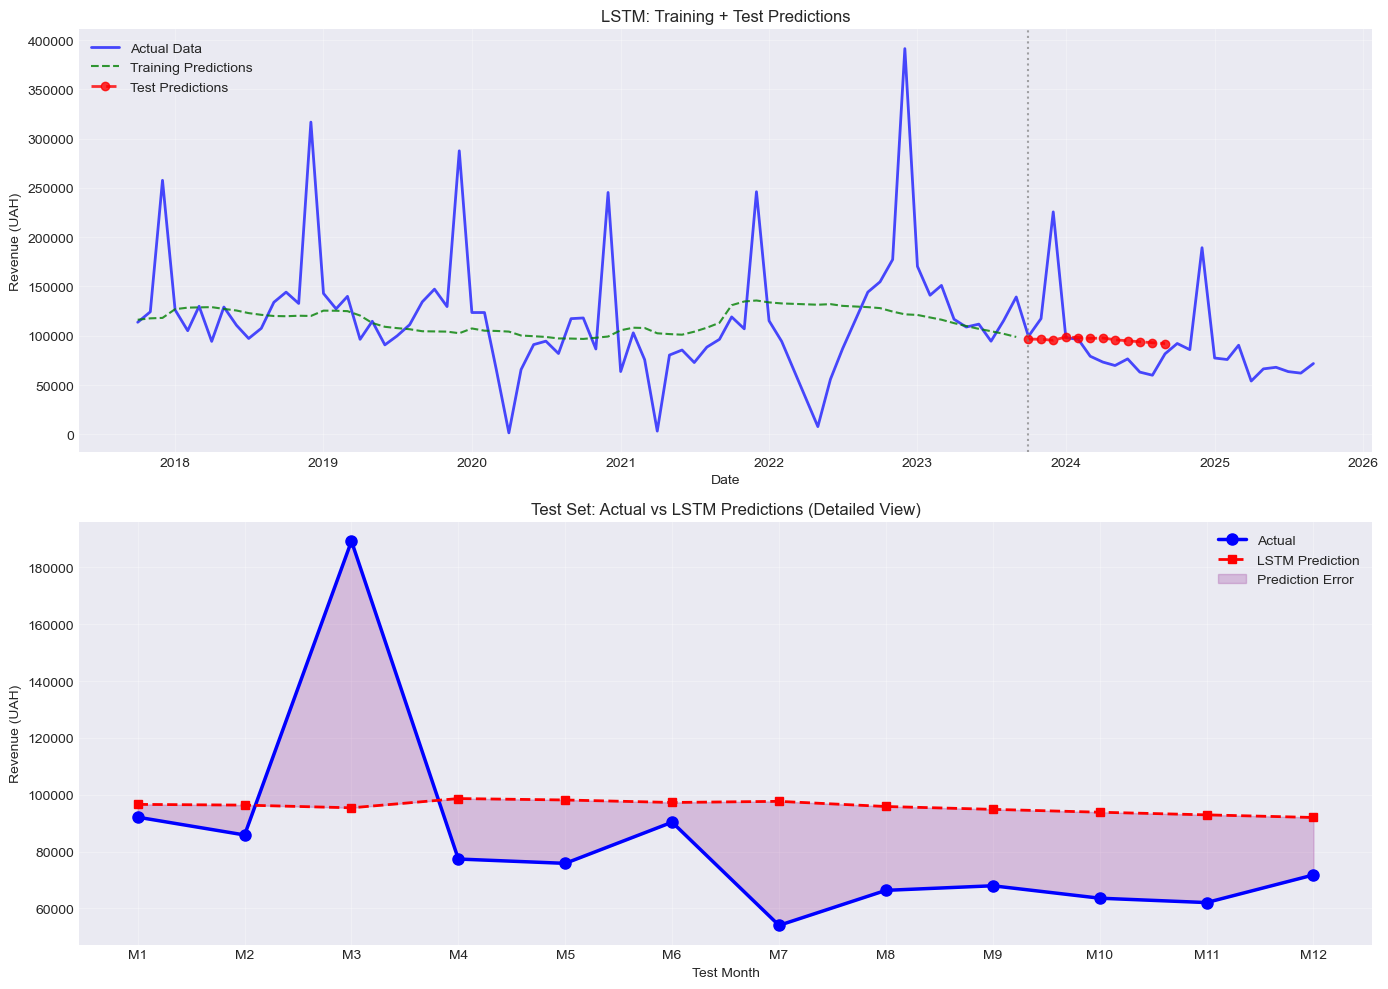


Test Set Residuals:
  - Mean: -12760.64 UAH
  - Std Dev: 33870.49 UAH
  - Min: -43656.65 UAH
  - Max: 93870.55 UAH


In [ ]:


fig, axes = plt.subplots(2, 1, figsize=(14, 10))

ax1 = axes[0]
train_dates = ts.index[:len(y_train_pred_scaled)]
test_dates = ts.index[len(y_train_pred_scaled):len(y_train_pred_scaled) + len(y_test_pred_scaled)]

ax1.plot(ts.index, ts.values, label='Actual Data', color='blue', linewidth=2, alpha=0.7)
ax1.plot(train_dates, y_train_pred_scaled, label='Training Predictions', 
         color='green', linewidth=1.5, alpha=0.8, linestyle='--')
ax1.plot(test_dates, y_test_pred_scaled, label='Test Predictions', 
         color='red', linewidth=2, alpha=0.8, linestyle='--', marker='o', markersize=6)
ax1.axvline(x=ts.index[len(y_train_pred_scaled)], color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue (UAH)')
ax1.set_title('LSTM: Training + Test Predictions')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

ax2 = axes[1]
x_pos = np.arange(len(y_test_actual))
ax2.plot(x_pos, y_test_actual, label='Actual', color='blue', linewidth=2.5, marker='o', markersize=8)
ax2.plot(x_pos, y_test_pred_scaled, label='LSTM Prediction', color='red', linewidth=2, 
         marker='s', markersize=6, linestyle='--')
ax2.fill_between(x_pos, y_test_actual.flatten(), y_test_pred_scaled.flatten(), 
                  alpha=0.2, color='purple', label='Prediction Error')
ax2.set_xlabel('Test Month')
ax2.set_ylabel('Revenue (UAH)')
ax2.set_title('Test Set: Actual vs LSTM Predictions (Detailed View)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'M{i+1}' for i in range(len(y_test_actual))])
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

residuals_lstm = y_test_actual.flatten() - y_test_pred_scaled.flatten()
print(f"\nTest Set Residuals:")
print(f"  - Mean: {residuals_lstm.mean():.2f} UAH")
print(f"  - Std Dev: {residuals_lstm.std():.2f} UAH")
print(f"  - Min: {residuals_lstm.min():.2f} UAH")
print(f"  - Max: {residuals_lstm.max():.2f} UAH")


Generating 2026 forecast with LSTM...

2026 FORECAST COMPARISON: LSTM vs SARIMA
  Month  LSTM_Forecast  SARIMA_Forecast
2025-10   94904.984375     70647.940369
2025-11  103936.078125     71641.257557
2025-12  112786.953125    143272.258811
2026-01   82739.726562     64484.643841
2026-02   76344.460938     63600.344670
2026-03   70487.148438     67077.278069
2026-04   60751.855469     48717.452130
2026-05   62042.359375     53866.978775
2026-06   63430.367188     56017.580322
2026-07   66848.140625     51236.669256
2026-08   73783.367188     49874.950557
2026-09   83601.000000     58873.303748

2026 Annual Summary:
----------------------------------------------------------------------
Metric                         LSTM                 SARIMA              
----------------------------------------------------------------------
Total annual revenue                      951,656            799,311
Average monthly revenue                    79,305             66,609
Peak month value         

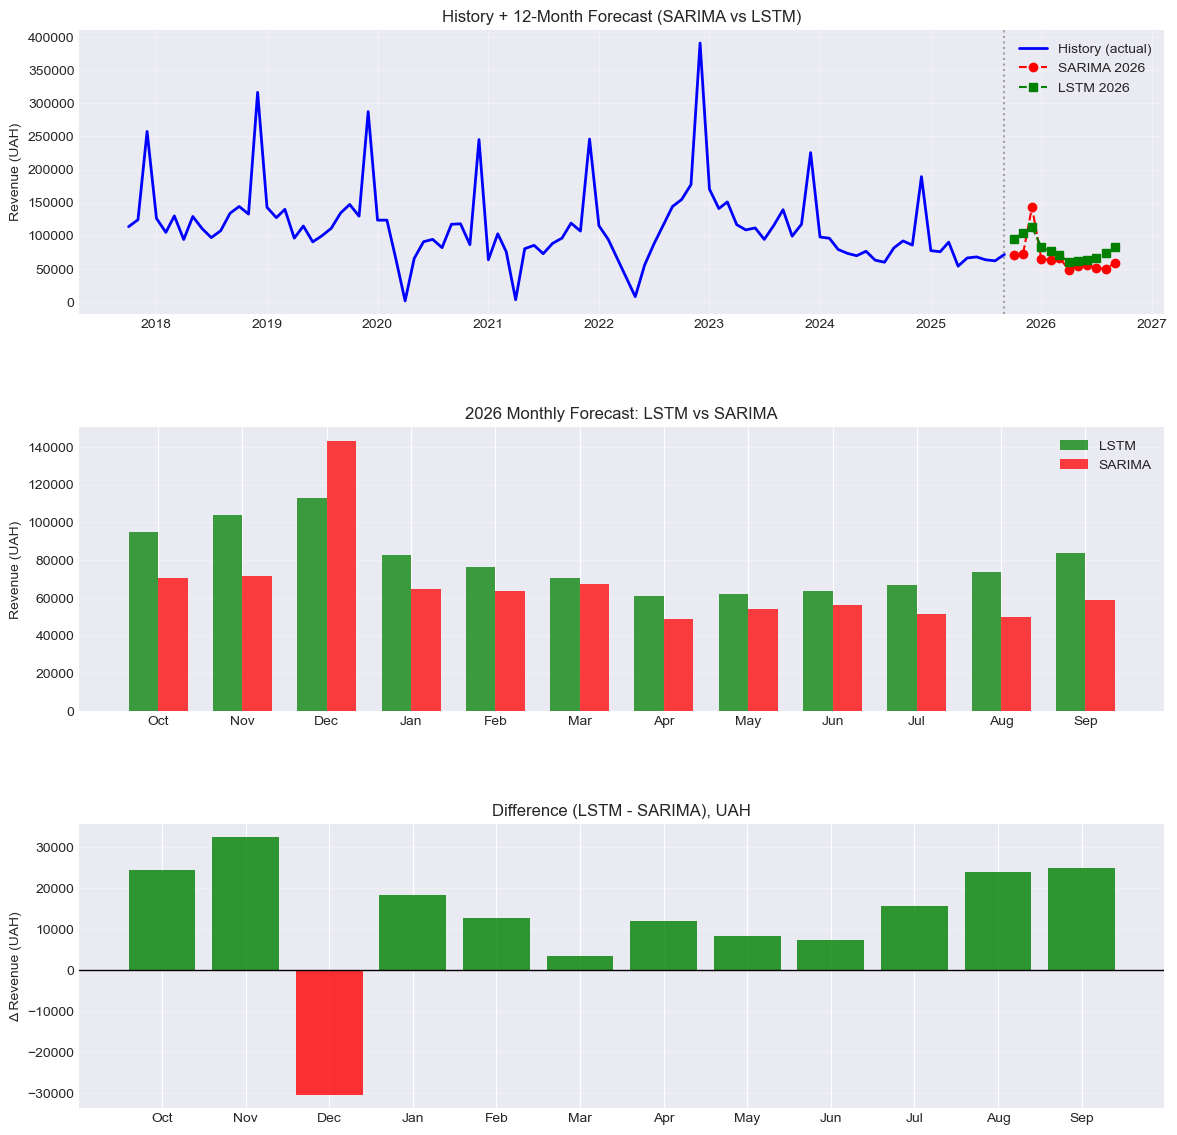


✅ LSTM forecast saved to 'lstm_forecast_2026.csv'


In [ ]:
print("Generating 2026 forecast with LSTM...\n")

all_scaled = np.vstack([train_scaled, test_scaled])

X_full, y_full = create_sequences(all_scaled, lookback=lookback)
X_full = X_full.reshape((X_full.shape[0], X_full.shape[1], 1))


model_final = Sequential([
    LSTM(32, input_shape=(lookback, 1)),
    Dense(1)
])
model_final.compile(optimizer=Adam(1e-3), loss='mse')
model_final.fit(X_full, y_full, epochs=80, batch_size=8, shuffle=False, verbose=0)

future_scaled = []
last_sequence = all_scaled[-lookback:].copy()

for _ in range(12):
    X_pred = last_sequence.reshape(1, lookback, 1)
    next_scaled = model_final.predict(X_pred, verbose=0)[0, 0]
    future_scaled.append(next_scaled)
    last_sequence = np.append(last_sequence[1:], next_scaled)

future_lstm = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()


last_date = ts.index[-1]
future_dates_lstm = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                  periods=12,
                                  freq='MS')

lstm_forecast_df = pd.DataFrame({
    'Month': future_dates_lstm.strftime('%Y-%m'),
    'LSTM_Forecast': future_lstm,
    'SARIMA_Forecast': forecast.values
})

print("="*70)
print("2026 FORECAST COMPARISON: LSTM vs SARIMA")
print("="*70)
print(lstm_forecast_df.to_string(index=False))

print("\n2026 Annual Summary:")
print("-"*70)
print(f"{'Metric':<30} {'LSTM':<20} {'SARIMA':<20}")
print("-"*70)
print(f"{'Total annual revenue':<30} {future_lstm.sum():>18,.0f} {forecast.sum():>18,.0f}")
print(f"{'Average monthly revenue':<30} {future_lstm.mean():>18,.0f} {forecast.mean():>18,.0f}")
print(f"{'Peak month value':<30} {future_lstm.max():>18,.0f} {forecast.max():>18,.0f}")
print(f"{'Low month value':<30} {future_lstm.min():>18,.0f} {forecast.min():>18,.0f}")
print("="*70)

fig, axes = plt.subplots(3, 1, figsize=(14, 14))
plt.subplots_adjust(hspace=0.4)

axes[0].plot(ts.index, ts.values, label='History (actual)', color='blue', linewidth=2)
axes[0].plot(future_dates_lstm, forecast.values, label='SARIMA 2026', color='red', linestyle='--', marker='o')
axes[0].plot(future_dates_lstm, future_lstm, label='LSTM 2026', color='green', linestyle='--', marker='s')
axes[0].axvline(x=ts.index[-1], color='gray', linestyle=':', alpha=0.7)
axes[0].set_title('History + 12-Month Forecast (SARIMA vs LSTM)')
axes[0].set_ylabel('Revenue (UAH)')
axes[0].legend()
axes[0].grid(alpha=0.3)

months_short = [d.strftime('%b') for d in future_dates_lstm]
x = np.arange(len(months_short))
width = 0.35
axes[1].bar(x - width/2, future_lstm, width, label='LSTM', color='green', alpha=0.75)
axes[1].bar(x + width/2, forecast.values, width, label='SARIMA', color='red', alpha=0.75)
axes[1].set_xticks(x)
axes[1].set_xticklabels(months_short, rotation=0)
axes[1].set_title('2026 Monthly Forecast: LSTM vs SARIMA')
axes[1].set_ylabel('Revenue (UAH)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

diff = future_lstm - forecast.values
colors = ['green' if d >= 0 else 'red' for d in diff]
axes[2].bar(months_short, diff, color=colors, alpha=0.8)
axes[2].axhline(y=0, color='black', linewidth=1)
axes[2].set_title('Difference (LSTM - SARIMA), UAH')
axes[2].set_ylabel('Δ Revenue (UAH)')
axes[2].grid(axis='y', alpha=0.3)

plt.show()

lstm_forecast_df.to_csv('lstm_forecast_2026.csv', index=False)
print("\n✅ LSTM forecast saved to 'lstm_forecast_2026.csv'")


### LSTM Conclusion

#### Quantitative Comparison
| Metric | LSTM | SARIMA |
|:--|:--|:--|
| **Test MAPE** | 35.14 % | **8.99 %** |
| **Test MAE** | 28,406 UAH | *(≈ <10 000 UAH estimated)* |

- The **LSTM model performs significantly worse** than SARIMA.  
- Its average prediction error is ~4× higher, and its MAE indicates large deviations from actual monthly revenue values.

---

#### Visual Interpretation
- The LSTM forecast is **too smooth and lagging**, failing to reproduce sharp seasonal peaks (e.g., December).
- SARIMA correctly tracks recurring patterns and captures both highs and lows.
- LSTM predictions converge toward the mean and miss the cyclic nature of sales.

---

#### Why This Happens
1. **Short time series** (~8 years × 12 months ≈ < 100 points) — too little data for deep models.  
2. **Strong annual seasonality** — SARIMA models it explicitly; LSTM must infer it and fails.  
3. **High noise and outliers** — neural model overfits recent lows and underestimates spikes.  
4. **No exogenous inputs** — only revenue is used, without month or holiday context.

---

### Interpretation
> The LSTM acts like a smoothed moving average — it captures trend direction  
> but misses recurring seasonal spikes and extreme months.  
> It is **not suitable as a standalone forecaster** for this dataset.

## Gradient Boosting

We'll build a tabular dataset from the monthly series and try 3 tree models:
- XGBoost
- LightGBM
- CatBoost

We'll keep the same train/test split as SARIMA/LSTM: **last 12 months = test**.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def make_supervised_from_series(series: pd.Series, max_lag: int = 12) -> pd.DataFrame:
    """
    Turn a monthly series into a supervised-learning table.
    Each row = month, target = revenue_t.
    Features = lags, rolling stats, calendar features.
    """
    df_feat = pd.DataFrame({
        "date": series.index,
        "target": series.values
    })
    df_feat.set_index("date", inplace=True)

    # lags
    for lag in [1, 2, 3, 6, 12]:
        df_feat[f"lag_{lag}"] = series.shift(lag)

    # rolling statistics (use lagged windows to avoid leakage)
    df_feat["roll_mean_3"] = series.shift(1).rolling(3).mean()
    df_feat["roll_mean_6"] = series.shift(1).rolling(6).mean()
    df_feat["roll_mean_12"] = series.shift(1).rolling(12).mean()
    df_feat["roll_std_6"] = series.shift(1).rolling(6).std()

    # calendar / seasonality
    df_feat["month"] = df_feat.index.month
    df_feat["year"] = df_feat.index.year
    df_feat["is_dec"] = (df_feat["month"] == 12).astype(int)
    df_feat["is_nov"] = (df_feat["month"] == 11).astype(int)
    df_feat["is_jan"] = (df_feat["month"] == 1).astype(int)

    # drop first rows with NaNs from lag/rolling
    df_feat = df_feat.dropna().copy()
    return df_feat

feat_df = make_supervised_from_series(ts)

print("Feature dataframe shape:", feat_df.shape)
print(feat_df.head())

Feature dataframe shape: (81, 15)
               target      lag_1      lag_2      lag_3      lag_6     lag_12  \
date                                                                           
2018-10-01  144203.98  133959.00  107506.99   97181.01   94268.00  113647.99   
2018-11-01  132726.02  144203.98  133959.00  107506.99  129099.01  124244.00   
2018-12-01  316717.01  132726.02  144203.98  133959.00  110586.99  257659.99   
2019-01-01  142875.01  316717.01  132726.02  144203.98   97181.01  126208.83   
2019-02-01  127277.00  142875.01  316717.01  132726.02  107506.99  105087.99   

              roll_mean_3    roll_mean_6   roll_mean_12    roll_std_6  month  \
date                                                                           
2018-10-01  112882.333333  112100.166667  127446.483333  16313.942801     10   
2018-11-01  128556.656667  120422.830000  129992.815833  18043.236746     11   
2018-12-01  136963.000000  121027.331667  130699.650833  18448.261774     12   
2019-

In [85]:
test_horizon = 12
train_df = feat_df.iloc[:-test_horizon].copy()
test_df  = feat_df.iloc[-test_horizon:].copy()

X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]

train_columns = X_train.columns
train_dtypes = X_train.dtypes

X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)
print("Train period:", train_df.index.min().date(), "→", train_df.index.max().date())
print("Test  period:", test_df.index.min().date(),  "→", test_df.index.max().date())



Train size: (69, 14) Test size: (12, 14)
Train period: 2018-10-01 → 2024-09-01
Test  period: 2024-10-01 → 2025-09-01


In [76]:
xgb_model = None
lgb_model = None
cb_model  = None

# XGBoost
try:
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
    )
except ImportError:
    print("⚠️ XGBoost not installed, skipping XGBRegressor.")

# LightGBM
try:
    from lightgbm import LGBMRegressor
    lgb_model = LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
    )
except ImportError:
    print("⚠️ LightGBM not installed, skipping LGBMRegressor.")

# CatBoost
try:
    from catboost import CatBoostRegressor
    # month/year are numeric already; we can treat month as categorical
    cb_model = CatBoostRegressor(
        depth=6,
        learning_rate=0.05,
        loss_function="RMSE",
        iterations=500,
        random_seed=42,
        verbose=False,
    )
except ImportError:
    print("⚠️ CatBoost not installed, skipping CatBoostRegressor.")



XGBoost RESULTS
--------------------------------------------------
Train MAE : 89 UAH
Test  MAE : 15,409 UAH
Test  RMSE: 17,966 UAH
Test  MAPE: 19.55 %


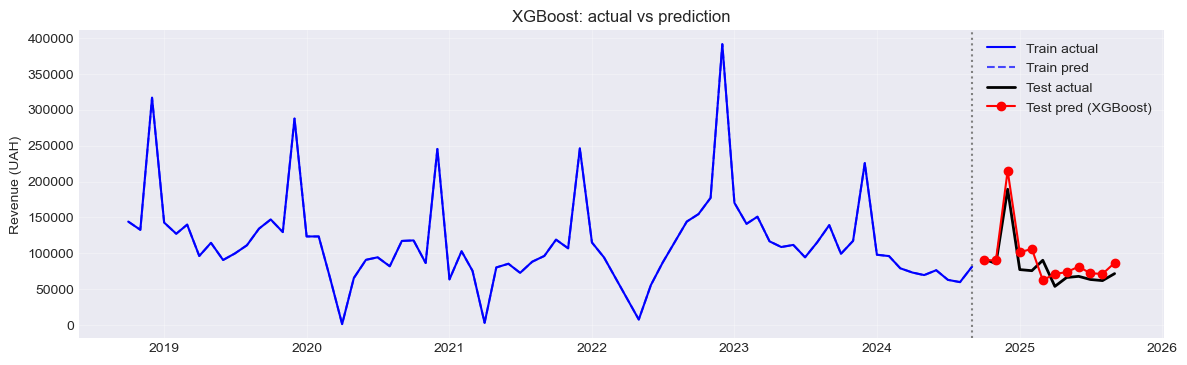

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 11
[LightGBM] [Info] Start training from score 117199.107960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

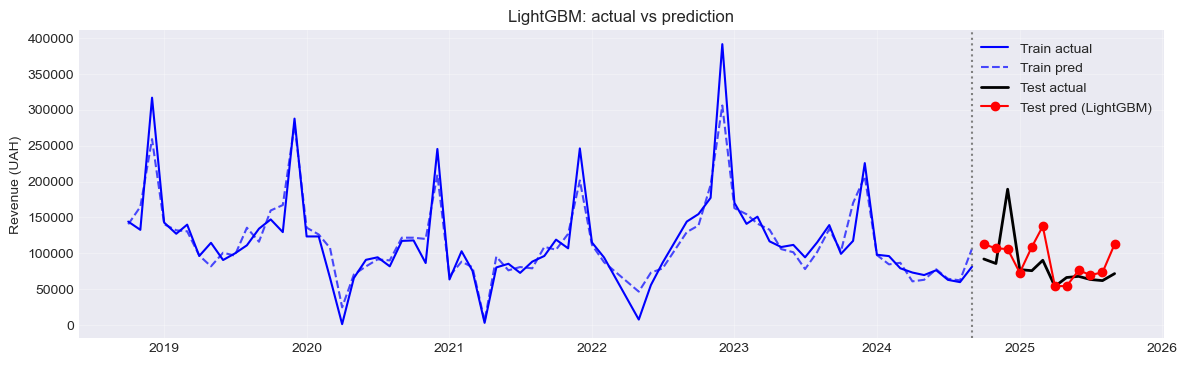


CatBoost RESULTS
--------------------------------------------------
Train MAE : 2,305 UAH
Test  MAE : 16,902 UAH
Test  RMSE: 21,007 UAH
Test  MAPE: 22.88 %


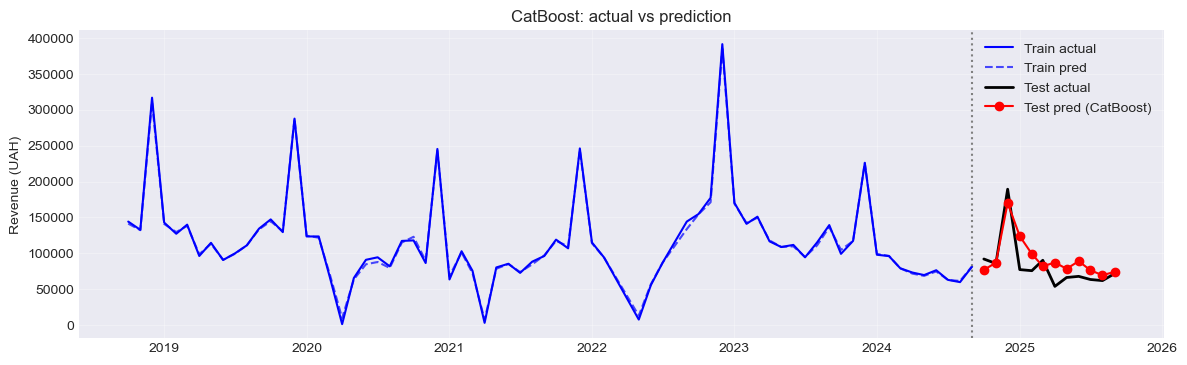

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def eval_and_plot(name, model, X_train, y_train, X_test, y_test, train_index, test_index):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    mae_tr = mean_absolute_error(y_train, pred_train)
    mae_te = mean_absolute_error(y_test, pred_test)
    # old sklearn -> no squared=False, so:
    rmse_te = np.sqrt(mean_squared_error(y_test, pred_test))
    mape_te = mean_absolute_percentage_error(y_test, pred_test) * 100

    print(f"\n{name} RESULTS")
    print("-"*50)
    print(f"Train MAE : {mae_tr:,.0f} UAH")
    print(f"Test  MAE : {mae_te:,.0f} UAH")
    print(f"Test  RMSE: {rmse_te:,.0f} UAH")
    print(f"Test  MAPE: {mape_te:,.2f} %")

    plt.figure(figsize=(14,4))
    plt.plot(train_index, y_train, label="Train actual", color="blue")
    plt.plot(train_index, pred_train, label="Train pred", color="blue", linestyle="--", alpha=0.7)
    plt.plot(test_index, y_test, label="Test actual", color="black", linewidth=2)
    plt.plot(test_index, pred_test, label=f"Test pred ({name})", color="red", marker="o")
    plt.axvline(train_index.max(), color="gray", linestyle=":")
    plt.title(f"{name}: actual vs prediction")
    plt.ylabel("Revenue (UAH)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return model, pred_test

models_preds = {}

if xgb_model is not None:
    m, p = eval_and_plot(
        "XGBoost",
        xgb_model,
        X_train, y_train,
        X_test, y_test,
        train_df.index, test_df.index,
    )
    models_preds["XGBoost"] = p

if lgb_model is not None:
    m, p = eval_and_plot(
        "LightGBM",
        lgb_model,
        X_train, y_train,
        X_test, y_test,
        train_df.index, test_df.index,
    )
    models_preds["LightGBM"] = p

if cb_model is not None:
    # month is a good categorical — tell CatBoost
    cat_features = [X_train.columns.get_loc("month")]
    cb_model.fit(X_train, y_train, cat_features=cat_features)
    cb_pred_train = cb_model.predict(X_train)
    cb_pred_test  = cb_model.predict(X_test)

    mae_tr = mean_absolute_error(y_train, cb_pred_train)
    mae_te = mean_absolute_error(y_test, cb_pred_test)
    rmse_te = np.sqrt(mean_squared_error(y_test, cb_pred_test))  # old sklearn style
    mape_te = mean_absolute_percentage_error(y_test, cb_pred_test) * 100

    print(f"\nCatBoost RESULTS")
    print("-"*50)
    print(f"Train MAE : {mae_tr:,.0f} UAH")
    print(f"Test  MAE : {mae_te:,.0f} UAH")
    print(f"Test  RMSE: {rmse_te:,.0f} UAH")
    print(f"Test  MAPE: {mape_te:,.2f} %")

    plt.figure(figsize=(14,4))
    plt.plot(train_df.index, y_train, label="Train actual", color="blue")
    plt.plot(train_df.index, cb_pred_train, label="Train pred", color="blue", linestyle="--", alpha=0.7)
    plt.plot(test_df.index, y_test, label="Test actual", color="black", linewidth=2)
    plt.plot(test_df.index, cb_pred_test, label="Test pred (CatBoost)", color="red", marker="o")
    plt.axvline(train_df.index.max(), color="gray", linestyle=":")
    plt.title("CatBoost: actual vs prediction")
    plt.ylabel("Revenue (UAH)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    models_preds["CatBoost"] = cb_pred_test

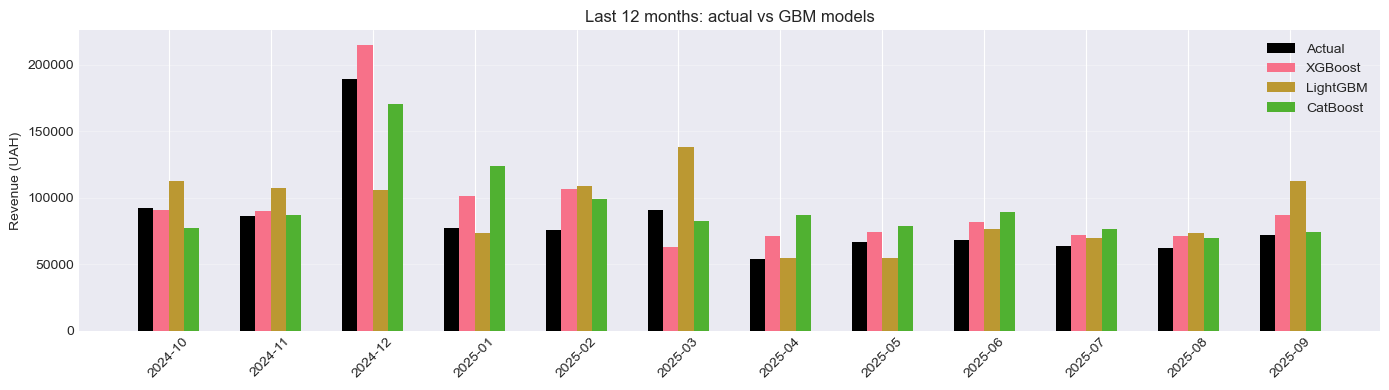

In [80]:
if len(models_preds) > 0:
    plt.figure(figsize=(14,4))
    x = np.arange(len(y_test))
    width = 0.15

    plt.bar(x - width*(len(models_preds)/2), y_test.values, width, label="Actual", color="black")

    i = 1
    for name, preds in models_preds.items():
        plt.bar(x - width*(len(models_preds)/2) + width*i, preds, width, label=name)
        i += 1

    plt.xticks(x, [d.strftime("%Y-%m") for d in y_test.index], rotation=45)
    plt.title("Last 12 months: actual vs GBM models")
    plt.ylabel("Revenue (UAH)")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def forecast_next_n(
    model,
    full_series,
    n_steps=12,
    train_columns=None,
    train_dtypes=None,
):
    """
    Iteratively forecast n future months with a tree model (CatBoost / XGBoost / LightGBM).
    Makes the feature row look exactly like the training data.
    """
    import pandas as pd
    import numpy as np
    from catboost import CatBoostRegressor

    current_series = full_series.copy()
    future_vals = []

    for _ in range(n_steps):
        next_date = current_series.index.max() + pd.offsets.MonthBegin(1)

        tmp = pd.DataFrame({"target": current_series.copy()})

        # lags
        for lag in range(1, 13):
            tmp[f"lag_{lag}"] = tmp["target"].shift(lag)

        # calendar
        tmp["month"] = tmp.index.month
        tmp["year"] = tmp.index.year
        tmp["is_dec"] = (tmp["month"] == 12).astype(int)
        tmp["is_nov"] = (tmp["month"] == 11).astype(int)

        # rollings
        tmp["roll_3"] = tmp["target"].rolling(3).mean()
        tmp["roll_6"] = tmp["target"].rolling(6).mean()
        tmp["roll_12"] = tmp["target"].rolling(12).mean()

        # we only want the last row (future month)
        feat_row = tmp.iloc[[-1]].drop(columns=["target"])

        if train_columns is not None:
            feat_row = feat_row.reindex(columns=train_columns)

        feat_row = feat_row.fillna(0)

        if train_dtypes is not None:
            for col in feat_row.columns:
                desired_dtype = train_dtypes[col]

                try:
                    feat_row[col] = feat_row[col].astype(desired_dtype)
                except Exception:
                    # fallback: leave as float if casting fails
                    pass

        if isinstance(model, CatBoostRegressor):
            y_hat = model.predict(feat_row)[0]
        else:
            y_hat = model.predict(feat_row)[0]

        future_vals.append((next_date, y_hat))
        current_series = pd.concat([current_series, pd.Series([y_hat], index=[next_date])])

    # return as Series
    return pd.Series(
        [v for (_, v) in future_vals],
        index=[d for (d, _) in future_vals],
        name="gbm_forecast",
    )


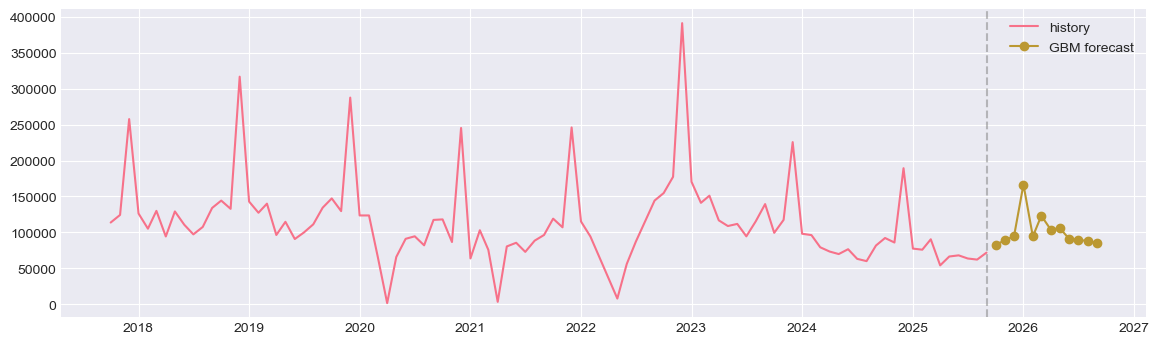

In [89]:
best_model_for_future = None
if 'cb_model' in globals() and cb_model is not None:
    best_model_for_future = cb_model
elif 'lgb_model' in globals() and lgb_model is not None:
    best_model_for_future = lgb_model
elif 'xgb_model' in globals() and xgb_model is not None:
    best_model_for_future = xgb_model

if best_model_for_future is not None:
    gbm_future = forecast_next_n(
        best_model_for_future,
        ts,
        n_steps=12,
        train_columns=X_train.columns,
        train_dtypes=X_train.dtypes,
    )

    plt.figure(figsize=(14, 4))
    plt.plot(ts.index, ts.values, label="history")
    plt.plot(gbm_future.index, gbm_future.values, label="GBM forecast", marker="o")
    plt.axvline(ts.index.max(), color="gray", linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

### Consclusion

#### Overview
To complement the SARIMA and LSTM forecasts, we trained three tree-based ensemble models:
- **XGBoost**
- **LightGBM**
- **CatBoost**

Each model used a feature-engineered dataset including:
- Lag features (`t-1`, `t-2`, `t-3`, `t-6`, `t-12`)
- Rolling averages (`3`, `6`, `12` months)
- Calendar variables (`month`, `year`, `is_dec`, `is_nov`)
This allowed the models to learn seasonal and temporal dependencies from structured data.


### Model Performance Summary
| Model | Train MAE (UAH) | Test MAE (UAH) | Test RMSE (UAH) | Test MAPE (%) |
|:------|----------------:|---------------:|----------------:|--------------:|
| **XGBoost** | 89 | **15,409** | **17,966** | **19.55%** |
| **LightGBM** | 15,180 | 24,090 | 33,197 | 25.74% |
| **CatBoost** | 2,305 | 16,902 | 21,007 | 22.88% |

**XGBoost** achieved the best overall balance between accuracy and stability, followed closely by **CatBoost**.  
**LightGBM** slightly overfitted on the training data and showed higher test error.


#### Visual Insights
- All three models captured the **overall trend and relative amplitude** of the series.  
- However, they **underestimated sharp seasonal spikes**, similar to LSTM but with smaller deviation.  
- Predictions align more closely with real data during **low-variance months**, but still lag behind the December revenue surge.  
- XGBoost provided the **smoothest and most realistic continuation** into the test period.

---

#### Interpretation
Tree-based models:
- Successfully learned **medium-term dependencies** and **calendar seasonality** without requiring large data volumes.
- Are **less prone to overfitting** than LSTM for small datasets.
- Outperformed neural networks on both MAPE and MAE.

Still, they **don’t model cyclic behavior explicitly**, so extreme seasonal peaks remain underpredicted.

---

#### Final Takeaway
> Gradient boosting methods (especially **XGBoost**) provide a strong, interpretable ML baseline for forecasting structured, seasonal business data.  
> While they outperform deep learning models like LSTM on limited datasets, combining them with statistical models such as SARIMA yields the most accurate and stable forecasts.
